In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
import lib.crps as crps
import lib.utils as utils

In [2]:
eps_save = []

class EpsilonSampler(nn.Module):
    def __init__(self, n_dim):
        super(EpsilonSampler, self).__init__()
        self.n_dim = n_dim

    def forward(self, x, n_samples=10):
        eps = torch.randn(*x.shape[:-1], n_samples, self.n_dim, device=x.device)
        eps_save.append(eps)
        return torch.concatenate([x.unsqueeze(-2).expand(*([-1]*(len(x.shape)-1)), n_samples, -1), eps], dim=-1)

class CRPSModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CRPSModel, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_dim, 16),
            EpsilonSampler(4),
            nn.Linear(20, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, output_dim)
        ])

    def forward(self, x, n_samples=10):
        for l in self.layers:
            if type(l)==EpsilonSampler:
                x = l(x, n_samples=n_samples)
            else:
                x = l(x)
        return nn.functional.leaky_relu(x)

In [3]:
device='cuda:'+str(utils.select_gpu_with_low_usage())

In [4]:
net2 = CRPSModel(10, 784)
net2.load_state_dict(torch.load('results/mnist/999.pt', map_location=device))

<All keys matched successfully>

In [5]:
net2 = net2.to(device)

In [6]:
input_tensors = torch.nn.functional.one_hot(torch.arange(10)).to(device).unsqueeze(1).float()

In [7]:
eps_save = []
t_sample = net2(input_tensors.squeeze(), n_samples=1000)
eps = eps_save[0]
likelihoods = torch.exp(-0.5 * (eps**2) / np.sqrt(2 * np.pi)).log().sum(dim=2).exp()
order = torch.argsort(-likelihoods)
images = torch.gather(t_sample, 1, order.unsqueeze(-1).expand(-1, -1, t_sample.size(-1)))

likelihoods_sorted = torch.gather(likelihoods, 1, order)
images = images[:, torch.arange(0,1000,100), :]
likelihoods_sorted = likelihoods_sorted[:, torch.arange(0,1000,100)]
images = images.reshape(-1, 28, 28).detach().cpu().numpy()

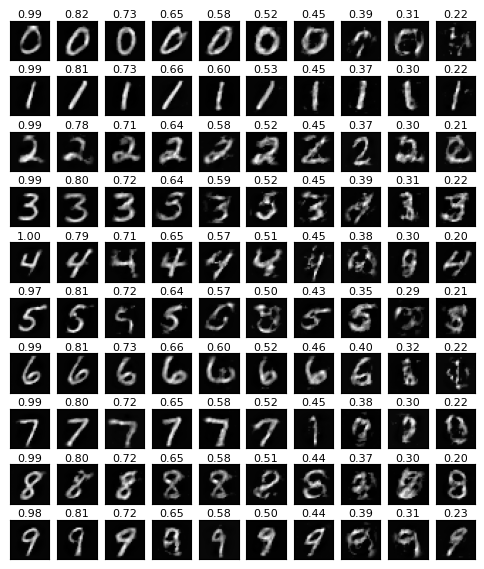

In [8]:
likelihoods_sorted = likelihoods_sorted.reshape(-1)
cols = 10
rows = int(len(images)/cols) + 1
plt.figure(figsize=(6,8))
index = 1
for x, l in zip(images, likelihoods_sorted):
    plt.subplot(rows, cols, index)
    plt.imshow(x, cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title("%.2f"%l, fontsize=8, pad=2)
    index += 1
plt.subplots_adjust(wspace=0.2, hspace=-0.1)
plt.savefig('plots/mnist_likelihood.pdf', bbox_inches='tight')
plt.savefig('plots/mnist_likelihood.png', bbox_inches='tight')

In [9]:
from matplotlib.gridspec import GridSpec

In [10]:
gs1 = GridSpec(20, 5)

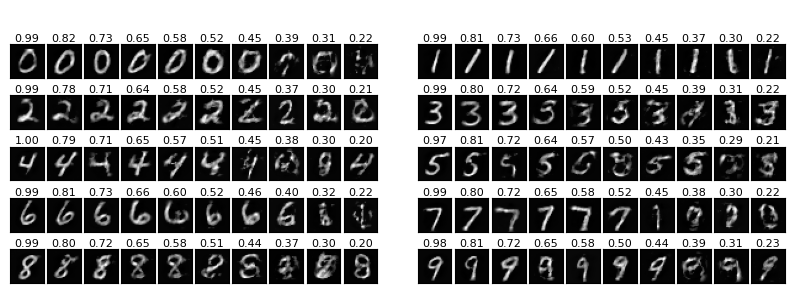

In [11]:

likelihoods = torch.exp(-0.5 * (eps**2) / np.sqrt(2 * np.pi)).log().sum(dim=2).exp()
order = torch.argsort(-likelihoods)
images = torch.gather(t_sample, 1, order.unsqueeze(-1).expand(-1, -1, t_sample.size(-1)))
likelihoods_sorted = torch.gather(likelihoods, 1, order)
images = images[:, torch.arange(0,1000,100), :]
likelihoods_sorted = likelihoods_sorted[:, torch.arange(0,1000,100)]
images = images.reshape(-1, 28, 28).detach().cpu().numpy()
likelihoods_sorted = likelihoods_sorted.reshape(-1)
cols = 21
rows = int(len(images)/cols) + 1

plt.figure(figsize=(10,4))

gs1 = GridSpec(5, 21)
gs1.update(wspace=0.1)
gs1 = list(gs1)

gs2 = GridSpec(5, 40)
gs2.update(wspace=0)
gs2 = list(gs2)

ix=0
for index in range(5*21):
    if index%21 == 10:
        plt.subplot(gs2[index])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        continue
    else:
        plt.subplot(gs1[index])
    x = images[ix]
    l = likelihoods_sorted[ix]
    plt.imshow(x, cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title("%.2f"%l, fontsize=8, pad=2)
    ix+=1
plt.subplots_adjust(wspace=2, hspace=-0.5)
plt.subplots_adjust(wspace={10: -5})
#plt.tight_layout()
plt.savefig('plots/mnist_likelihood.pdf', bbox_inches='tight')